# Project Proposal - Data Preparation and Exploration
<br>Group: Group 11 - Alex Fung, Patrick Osborne
<br>Dataset: Twitter US Airline Sentiment
<br>Dataset link: https://www.kaggle.com/crowdflower/twitter-airline-sentiment



## Data Preparation

### Load the data

In [1]:
import pandas as pd
pd.options.display.max_colwidth = None

It is important that we read the Tweets.csv with 'utf-8' encoding, so that we can extract the emojis properly

In [2]:
df_tweets = pd.read_csv("../data/Tweets.csv", encoding='utf-8')
df_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
df_tweets.shape

(14640, 15)

### Check for Nulls

There are no nulls amongst the columns airline_sentiment and text, which is good

In [4]:
df_tweets['airline_sentiment'].isnull().sum()

0

In [5]:
df_tweets['text'].isnull().sum()

0

Column 'negativereason' has a few missing nulls, but they are null only if 'airline_sentiment' is positive or neutral.

In [6]:
df_tweets['negativereason'].isnull().sum()

5462

In [7]:
df_tweets['airline_sentiment'].loc[df_tweets['negativereason'].isnull()].unique()

array(['neutral', 'positive'], dtype=object)

## Cleaning Data

### 1. Remove not useful columns
Looking at the dataframe above, we can see some columns will likely not be useful for our purposes of sentiment analysis, such timezones, number of retweets, etc. 

In [8]:
df_tweets = df_tweets[
    ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'text']
]
df_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,text
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,@VirginAmerica What @dhepburn said.
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,@VirginAmerica plus you've added commercials to the experience... tacky.
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,@VirginAmerica and it's a really big bad thing about it


### 2.Create new column 'text_cleaned'
We create a column 'text_cleaned' that will contain the cleaned up version of 'text' column 

In [9]:
df_tweets['text_cleaned'] = df_tweets['text']

### 3. Remove HTML encoding
The text has not been cleaned, as there is some HTML encoding left in the text, such as "&/amp;". We will use BeautifulSoup and lxml package to remove the HTML encoding from the text.

#### Sanity Check

In [10]:
from bs4 import BeautifulSoup

#Example of what BeautifulSoup with lxml package does 
#you may need to install lxml by 'pip install lxml' for this to work, then restart kernel
example1 = BeautifulSoup('Disappointed,UNITED did NOT feed small CHILDREN on a 5 &amp; half hour flight', 'lxml')
print(example1.get_text())

Disappointed,UNITED did NOT feed small CHILDREN on a 5 & half hour flight


#### Remove HTML Encoding from text

In [11]:
df_tweets['text_cleaned'] = df_tweets['text_cleaned'].apply(lambda text: BeautifulSoup(text, 'lxml').get_text())
df_tweets['text_cleaned']

0                                                                                                                           @VirginAmerica What @dhepburn said.
1                                                                                      @VirginAmerica plus you've added commercials to the experience... tacky.
2                                                                                       @VirginAmerica I didn't today... Must mean I need to take another trip!
3                                    @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces & they have little recourse
4                                                                                                       @VirginAmerica and it's a really big bad thing about it
                                                                                  ...                                                                          
14635                                   

### 4. Remove retweets
Retweets are denoted in 'text' column as 'RT @another_user another_user's tweet'. We should remove retweets because we need to analyze the tweets of the users, not the retweets. In this situation, retweets  provide no real value to our text exploration analysis as normally the users retweet to the airlines, so the retweets are based off the tweets from the specified airlines' Twitter PR, which are likely going to be either of neutral or positive sentiment. Removing such retweets will hopefully remove any noise that will prevent the models from classifying sentiment.

In addition to removing retweets first, we will remove any remaining mentions afterwards.

#### Sanity Check

In [12]:
regex_to_replace= r'RT \@.*'
replace_value= ''

In [13]:
import re
example1 = 'Awesome! RT @VirginAmerica: Watch nominated films at 35,000 feet. #MeetTheFleet #Oscars http://t.co/DnStITRzWy'
example1 = re.sub(regex_to_replace, replace_value, example1)
example1

'Awesome! '

#### Remove retweets from text

In [14]:
df_tweets['text_cleaned'] = df_tweets['text_cleaned'].replace(to_replace=regex_to_replace, value=replace_value, regex=True)
df_tweets['text_cleaned']

0                                                                                                                           @VirginAmerica What @dhepburn said.
1                                                                                      @VirginAmerica plus you've added commercials to the experience... tacky.
2                                                                                       @VirginAmerica I didn't today... Must mean I need to take another trip!
3                                    @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces & they have little recourse
4                                                                                                       @VirginAmerica and it's a really big bad thing about it
                                                                                  ...                                                                          
14635                                   

### 5. Remove mentions
Sometimes, users use mentions (for example, tweet mentions include @VirginAirlines, @JetBlue, etc., in other words, the airlines' handle). They normally appear in the beginning of the users' tweets.

#### Sanity Check

In [15]:
regex_to_replace = r'\@[\w\d]*'
replace_value= ''

In [16]:
import re
example1 = '@VirginAmerica Thank you for the follow'
example1 = re.sub(regex_to_replace, replace_value, example1)
example1

' Thank you for the follow'

#### Remove mentions from text

In [17]:
df_tweets['text_cleaned'] = df_tweets['text_cleaned'].replace(to_replace=regex_to_replace, value=replace_value, regex=True)
df_tweets['text_cleaned']

0                                                                                                                                       What  said.
1                                                                                         plus you've added commercials to the experience... tacky.
2                                                                                          I didn't today... Must mean I need to take another trip!
3                                       it's really aggressive to blast obnoxious "entertainment" in your guests' faces & they have little recourse
4                                                                                                          and it's a really big bad thing about it
                                                                            ...                                                                    
14635                                                                                            thank you we go

### 6. Remove HTTP links
Should the user attach http links, we need to remove HTTP links from the text, since they provide no real value to our sentiment analysis as well. From what we can see in the data, they are mostly links to articles.

#### Sanity Check

In [18]:
regex_to_replace = r'https*://[^\s]*'
replace_value = ''

In [19]:
import re
example1 = '@VirginAmerica when are you putting some great deals from PDX to LAS or from LAS to PDX show me your love! http://t.co/enIQg0buzj'
example1 = re.sub(regex_to_replace, replace_value, example1)
example1

'@VirginAmerica when are you putting some great deals from PDX to LAS or from LAS to PDX show me your love! '

#### Removing HTTP Links from text

In [20]:
df_tweets['text_cleaned'] = df_tweets['text_cleaned'].replace(to_replace=regex_to_replace, value=replace_value, regex=True)
df_tweets['text_cleaned']

0                                                                                                                                       What  said.
1                                                                                         plus you've added commercials to the experience... tacky.
2                                                                                          I didn't today... Must mean I need to take another trip!
3                                       it's really aggressive to blast obnoxious "entertainment" in your guests' faces & they have little recourse
4                                                                                                          and it's a really big bad thing about it
                                                                            ...                                                                    
14635                                                                                            thank you we go

### 7. Extract Emojis and Emoticons
Rather than removing emojis and emoticons, emojis and emoticons can be seen as an integral part of the Internet language. Therefore, we should extract emojis and emoticons from the text if they exist, as they may be good features for sentiment analysis for "Internet"-speak.

Emojis are special characters which are shown as actual visual images, whereas emoticons are keyboard characters arranged in a certain format so that it represents a human-like facial expression.

We will use a third-party Python library called 'emot', which provides the ability to recognize and extract both emojis and emoticons. Github can be found here: https://github.com/NeelShah18/emot


#### Sanity Check

In [21]:
#Sanity check
import emot
text = "I love python 👨 :-)"
print(emot.emoji(text))
print(emot.emoticons(text))

{'value': ['👨'], 'mean': [':man:'], 'location': [[14, 14]], 'flag': True}
{'value': [':-)'], 'location': [[16, 19]], 'mean': ['Happy face smiley'], 'flag': True}


In [22]:
df_example1 = df_tweets.loc[df_tweets['tweet_id'] == 569198104806699008]
print(df_example1['text_cleaned'].to_string(index=False))
print(emot.emoji(df_example1['text_cleaned'].to_string(index=False)))
print(emot.emoticons(df_example1['text_cleaned'].to_string(index=False)))

  hahaha 😂 YOU GUYS ARE AMAZING. I LOVE YOU GUYS!!!💗
{'value': ['😂', '💗'], 'mean': [':face_with_tears_of_joy:', ':growing_heart:'], 'location': [[9, 9], [51, 51]], 'flag': True}
{'value': [], 'location': [], 'mean': [], 'flag': False}


In [23]:
df_example2 = df_tweets.loc[df_tweets['tweet_id'] == 568890074164809728]
print(df_example2['text_cleaned'].to_string(index=False))
print(emot.emoji(df_example2['text_cleaned'].to_string(index=False)))
print(emot.emoticons(df_example2['text_cleaned'].to_string(index=False)))

  we have a hot female pilot! Sweet! DCA to SFO! :-)
{'value': [], 'mean': [], 'location': [], 'flag': False}
{'value': [':-)'], 'location': [[49, 52]], 'mean': ['Happy face smiley'], 'flag': True}


#### Extracing Emojis and Emoticons from text

In [24]:
#this function will remove any emojis 
#accepts the following parameters: 
#(1) text_cleaned: roughly cleaned text in String o parse through and remove emojis
#(2) emojis: emojis object created by emot.emoji() (for more information see above)

#returns the cleaned up text without emojis

import ast

def remove_emojis(text_cleaned, emojis_string):
    #emojis_dict = emojis.to_dict()
    emojis_dict = ast.literal_eval(emojis_string)
    
    text_cleaned_no_emojis = ''
    
    print(emojis_dict)
    
    #if flag is True, that means there are emojis, and we need to remove them
    if emojis_dict['flag'] == True:
        for i in emojis_dict['value']:
            
            #rather than use location, we will match by String and see if we can remove it, because I'm lazy af lol 
            text_cleaned_no_emojis = text_cleaned.replace(i, "")
            
    if text_cleaned_no_emojis == '':
        print('Uh...Houston we have a problem for: ' + text_cleaned)
        print('The following emojis were not removed: ' + emojis)
        
    
    return text_cleaned_no_emojis  


In [25]:
#Testing above function
df_example1 = df_tweets_2.loc[df_tweets_2['tweet_id'] == 569198104806699008]
print(df_example1['text_cleaned'].to_string(index=False))
lol = remove_emojis(df_example1['text_cleaned'].to_string(index=False), df_example1['emojis'].to_string(index=False))
print(df_example1['emojis'])
print(lol)

NameError: name 'df_tweets_2' is not defined

In [ ]:
#this function will remove any emoticons
#accepts the following parameters: 
#(1) text_cleaned: roughly cleaned text in String o parse through and remove emojis and emoticons
#(2) emoticons: emoticons object created by emot.emoji() (for more information see above)

#returns the cleaned up text without emoticons 

def remove_emoticons(text_cleaned, emoticons):
    

In [52]:
#this function will extract any emojis into a separate 'emojis' column,
#while also removing said emojis from column: 'text_cleaned' 
#to form a new column: 'text_cleaned_without_emojis_emoticons'

#returns dataframe with the aforementioned new columns

import emot

#in 'emojis_emoticons' column, it will hold the emot.emoji return dictionary (see above for examples)
def extract_emojis(df_tweets):
    df_tweets_2 = df_tweets
    df_tweets_2['emojis_flag'] = ''
    df_tweets_2['emojis'] = ''
    df_tweets_2['emoticons_flag'] = ''
    df_tweets_2['emoticons'] = ''
        
    #easier to just write out code to loop through dataframe
    for i, row in df_tweets_2.iterrows():
        #print(i)
        #print(row)
        text_cleaned = df_tweets_2.at[i, 'text_cleaned']
        emojis = emot.emoji(text_cleaned)
        emoticons = emot.emoticons(text_cleaned)
        #print('EMOJIS: ' + str(emojis))
        #print('EMOTICONS: ' + str(emoticons))
        
        try: 
            df_tweets_2.at[i, 'emojis_flag'] = emojis['flag']
        except:
            print('Unable to grab emojis flag at row number: ' + str(i))
            df_tweets_2.at[i, 'emojis_flag'] = False
            
        try: 
             df_tweets_2.at[i, 'emojis'] = emojis['value']
        except: 
            print('Unable to grab emojis value at row number: ' + str(i))
            df_tweets_2.at[i, 'emojis'] = []
            
        try: 
            df_tweets_2.at[i, 'emoticons_flag'] = emoticons['flag']
        except: 
            print('Unable to grab emoticons flag at row number: ' + str(i))
            df_tweets_2.at[i, 'emoticons_flag'] = False
            
            
        try: 
            df_tweets_2.at[i, 'emoticons'] = emoticons['value']
        except: 
            print('Unable to grab emoticons value at row number: ' + str(i))
            df_tweets_2.at[i, 'emoticons'] = []
    
        #afterwards, we need to remove emojis and emoticons from the
        df_tweets_2.at[i, 'text_cleaned_without_emojis_emoticons'] = remove_emojis(
            text_cleaned,
            emojis
        )
        
    return df_tweets_2

In [54]:
#df_tweets['text_cleaned'] = df_tweets['text_cleaned'].apply(lambda text: BeautifulSoup(text, 'lxml').get_text())
#df_tweets['text_cleaned']
df_tweets_2 = extract_emojis(df_tweets)
df_tweets_2.head()

Unable to grab emoticons flag at row number: 1
Unable to grab emoticons value at row number: 1
Unable to grab emoticons flag at row number: 9
Unable to grab emoticons value at row number: 9
Unable to grab emoticons flag at row number: 22
Unable to grab emoticons value at row number: 22
Unable to grab emoticons flag at row number: 23
Unable to grab emoticons value at row number: 23
Unable to grab emoticons flag at row number: 26
Unable to grab emoticons value at row number: 26
Unable to grab emoticons flag at row number: 27
Unable to grab emoticons value at row number: 27
Unable to grab emoticons flag at row number: 29
Unable to grab emoticons value at row number: 29
Unable to grab emoticons flag at row number: 30
Unable to grab emoticons value at row number: 30
Unable to grab emoticons flag at row number: 32
Unable to grab emoticons value at row number: 32
Unable to grab emoticons flag at row number: 36
Unable to grab emoticons value at row number: 36
Unable to grab emoticons flag at r

Unable to grab emoticons flag at row number: 813
Unable to grab emoticons value at row number: 813
Unable to grab emoticons flag at row number: 817
Unable to grab emoticons value at row number: 817
Unable to grab emoticons flag at row number: 827
Unable to grab emoticons value at row number: 827
Unable to grab emoticons flag at row number: 829
Unable to grab emoticons value at row number: 829
Unable to grab emoticons flag at row number: 833
Unable to grab emoticons value at row number: 833
Unable to grab emoticons flag at row number: 834
Unable to grab emoticons value at row number: 834
Unable to grab emoticons flag at row number: 836
Unable to grab emoticons value at row number: 836
Unable to grab emoticons flag at row number: 841
Unable to grab emoticons value at row number: 841
Unable to grab emoticons flag at row number: 842
Unable to grab emoticons value at row number: 842
Unable to grab emoticons flag at row number: 843
Unable to grab emoticons value at row number: 843
Unable to 

Unable to grab emoticons flag at row number: 1517
Unable to grab emoticons value at row number: 1517
Unable to grab emoticons flag at row number: 1528
Unable to grab emoticons value at row number: 1528
Unable to grab emoticons flag at row number: 1529
Unable to grab emoticons value at row number: 1529
Unable to grab emoticons flag at row number: 1530
Unable to grab emoticons value at row number: 1530
Unable to grab emoticons flag at row number: 1532
Unable to grab emoticons value at row number: 1532
Unable to grab emoticons flag at row number: 1535
Unable to grab emoticons value at row number: 1535
Unable to grab emoticons flag at row number: 1537
Unable to grab emoticons value at row number: 1537
Unable to grab emoticons flag at row number: 1538
Unable to grab emoticons value at row number: 1538
Unable to grab emoticons flag at row number: 1540
Unable to grab emoticons value at row number: 1540
Unable to grab emoticons flag at row number: 1546
Unable to grab emoticons value at row num

Unable to grab emoticons flag at row number: 2321
Unable to grab emoticons value at row number: 2321
Unable to grab emoticons flag at row number: 2324
Unable to grab emoticons value at row number: 2324
Unable to grab emoticons flag at row number: 2327
Unable to grab emoticons value at row number: 2327
Unable to grab emoticons flag at row number: 2335
Unable to grab emoticons value at row number: 2335
Unable to grab emoticons flag at row number: 2336
Unable to grab emoticons value at row number: 2336
Unable to grab emoticons flag at row number: 2339
Unable to grab emoticons value at row number: 2339
Unable to grab emoticons flag at row number: 2343
Unable to grab emoticons value at row number: 2343
Unable to grab emoticons flag at row number: 2348
Unable to grab emoticons value at row number: 2348
Unable to grab emoticons flag at row number: 2359
Unable to grab emoticons value at row number: 2359
Unable to grab emoticons flag at row number: 2364
Unable to grab emoticons value at row num

Unable to grab emoticons flag at row number: 2916
Unable to grab emoticons value at row number: 2916
Unable to grab emoticons flag at row number: 2919
Unable to grab emoticons value at row number: 2919
Unable to grab emoticons flag at row number: 2920
Unable to grab emoticons value at row number: 2920
Unable to grab emoticons flag at row number: 2936
Unable to grab emoticons value at row number: 2936
Unable to grab emoticons flag at row number: 2942
Unable to grab emoticons value at row number: 2942
Unable to grab emoticons flag at row number: 2943
Unable to grab emoticons value at row number: 2943
Unable to grab emoticons flag at row number: 2944
Unable to grab emoticons value at row number: 2944
Unable to grab emoticons flag at row number: 2945
Unable to grab emoticons value at row number: 2945
Unable to grab emoticons flag at row number: 2946
Unable to grab emoticons value at row number: 2946
Unable to grab emoticons flag at row number: 2949
Unable to grab emoticons value at row num

Unable to grab emoticons flag at row number: 3573
Unable to grab emoticons value at row number: 3573
Unable to grab emoticons flag at row number: 3574
Unable to grab emoticons value at row number: 3574
Unable to grab emoticons flag at row number: 3579
Unable to grab emoticons value at row number: 3579
Unable to grab emoticons flag at row number: 3580
Unable to grab emoticons value at row number: 3580
Unable to grab emoticons flag at row number: 3590
Unable to grab emoticons value at row number: 3590
Unable to grab emoticons flag at row number: 3591
Unable to grab emoticons value at row number: 3591
Unable to grab emoticons flag at row number: 3595
Unable to grab emoticons value at row number: 3595
Unable to grab emoticons flag at row number: 3601
Unable to grab emoticons value at row number: 3601
Unable to grab emoticons flag at row number: 3607
Unable to grab emoticons value at row number: 3607
Unable to grab emoticons flag at row number: 3608
Unable to grab emoticons value at row num

Unable to grab emoticons value at row number: 4266
Unable to grab emoticons flag at row number: 4279
Unable to grab emoticons value at row number: 4279
Unable to grab emoticons flag at row number: 4281
Unable to grab emoticons value at row number: 4281
Unable to grab emoticons flag at row number: 4284
Unable to grab emoticons value at row number: 4284
Unable to grab emoticons flag at row number: 4290
Unable to grab emoticons value at row number: 4290
Unable to grab emoticons flag at row number: 4291
Unable to grab emoticons value at row number: 4291
Unable to grab emoticons flag at row number: 4302
Unable to grab emoticons value at row number: 4302
Unable to grab emoticons flag at row number: 4304
Unable to grab emoticons value at row number: 4304
Unable to grab emoticons flag at row number: 4312
Unable to grab emoticons value at row number: 4312
Unable to grab emoticons flag at row number: 4318
Unable to grab emoticons value at row number: 4318
Unable to grab emoticons flag at row num

Unable to grab emoticons flag at row number: 4935
Unable to grab emoticons value at row number: 4935
Unable to grab emoticons flag at row number: 4936
Unable to grab emoticons value at row number: 4936
Unable to grab emoticons flag at row number: 4941
Unable to grab emoticons value at row number: 4941
Unable to grab emoticons flag at row number: 4942
Unable to grab emoticons value at row number: 4942
Unable to grab emoticons flag at row number: 4949
Unable to grab emoticons value at row number: 4949
Unable to grab emoticons flag at row number: 4953
Unable to grab emoticons value at row number: 4953
Unable to grab emoticons flag at row number: 4954
Unable to grab emoticons value at row number: 4954
Unable to grab emoticons flag at row number: 4956
Unable to grab emoticons value at row number: 4956
Unable to grab emoticons flag at row number: 4957
Unable to grab emoticons value at row number: 4957
Unable to grab emoticons flag at row number: 4958
Unable to grab emoticons value at row num

Unable to grab emoticons flag at row number: 5618
Unable to grab emoticons value at row number: 5618
Unable to grab emoticons flag at row number: 5634
Unable to grab emoticons value at row number: 5634
Unable to grab emoticons flag at row number: 5639
Unable to grab emoticons value at row number: 5639
Unable to grab emoticons flag at row number: 5640
Unable to grab emoticons value at row number: 5640
Unable to grab emoticons flag at row number: 5654
Unable to grab emoticons value at row number: 5654
Unable to grab emoticons flag at row number: 5656
Unable to grab emoticons value at row number: 5656
Unable to grab emoticons flag at row number: 5661
Unable to grab emoticons value at row number: 5661
Unable to grab emoticons flag at row number: 5688
Unable to grab emoticons value at row number: 5688
Unable to grab emoticons flag at row number: 5708
Unable to grab emoticons value at row number: 5708
Unable to grab emoticons flag at row number: 5710
Unable to grab emoticons value at row num

Unable to grab emoticons flag at row number: 6459
Unable to grab emoticons value at row number: 6459
Unable to grab emoticons flag at row number: 6464
Unable to grab emoticons value at row number: 6464
Unable to grab emoticons flag at row number: 6466
Unable to grab emoticons value at row number: 6466
Unable to grab emoticons flag at row number: 6469
Unable to grab emoticons value at row number: 6469
Unable to grab emoticons flag at row number: 6472
Unable to grab emoticons value at row number: 6472
Unable to grab emoticons flag at row number: 6473
Unable to grab emoticons value at row number: 6473
Unable to grab emoticons flag at row number: 6479
Unable to grab emoticons value at row number: 6479
Unable to grab emoticons flag at row number: 6486
Unable to grab emoticons value at row number: 6486
Unable to grab emoticons flag at row number: 6490
Unable to grab emoticons value at row number: 6490
Unable to grab emoticons flag at row number: 6496
Unable to grab emoticons value at row num

Unable to grab emoticons flag at row number: 7668
Unable to grab emoticons value at row number: 7668
Unable to grab emoticons flag at row number: 7669
Unable to grab emoticons value at row number: 7669
Unable to grab emoticons flag at row number: 7679
Unable to grab emoticons value at row number: 7679
Unable to grab emoticons flag at row number: 7680
Unable to grab emoticons value at row number: 7680
Unable to grab emoticons flag at row number: 7682
Unable to grab emoticons value at row number: 7682
Unable to grab emoticons flag at row number: 7703
Unable to grab emoticons value at row number: 7703
Unable to grab emoticons flag at row number: 7711
Unable to grab emoticons value at row number: 7711
Unable to grab emoticons flag at row number: 7716
Unable to grab emoticons value at row number: 7716
Unable to grab emoticons flag at row number: 7723
Unable to grab emoticons value at row number: 7723
Unable to grab emoticons flag at row number: 7726
Unable to grab emoticons value at row num

Unable to grab emoticons flag at row number: 8510
Unable to grab emoticons value at row number: 8510
Unable to grab emoticons flag at row number: 8512
Unable to grab emoticons value at row number: 8512
Unable to grab emoticons flag at row number: 8514
Unable to grab emoticons value at row number: 8514
Unable to grab emoticons flag at row number: 8520
Unable to grab emoticons value at row number: 8520
Unable to grab emoticons flag at row number: 8528
Unable to grab emoticons value at row number: 8528
Unable to grab emoticons flag at row number: 8531
Unable to grab emoticons value at row number: 8531
Unable to grab emoticons flag at row number: 8532
Unable to grab emoticons value at row number: 8532
Unable to grab emoticons flag at row number: 8535
Unable to grab emoticons value at row number: 8535
Unable to grab emoticons flag at row number: 8546
Unable to grab emoticons value at row number: 8546
Unable to grab emoticons flag at row number: 8551
Unable to grab emoticons value at row num

Unable to grab emoticons flag at row number: 9363
Unable to grab emoticons value at row number: 9363
Unable to grab emoticons flag at row number: 9364
Unable to grab emoticons value at row number: 9364
Unable to grab emoticons flag at row number: 9368
Unable to grab emoticons value at row number: 9368
Unable to grab emoticons flag at row number: 9376
Unable to grab emoticons value at row number: 9376
Unable to grab emoticons flag at row number: 9380
Unable to grab emoticons value at row number: 9380
Unable to grab emoticons flag at row number: 9387
Unable to grab emoticons value at row number: 9387
Unable to grab emoticons flag at row number: 9388
Unable to grab emoticons value at row number: 9388
Unable to grab emoticons flag at row number: 9391
Unable to grab emoticons value at row number: 9391
Unable to grab emoticons flag at row number: 9392
Unable to grab emoticons value at row number: 9392
Unable to grab emoticons flag at row number: 9394
Unable to grab emoticons value at row num

Unable to grab emoticons flag at row number: 10249
Unable to grab emoticons value at row number: 10249
Unable to grab emoticons flag at row number: 10250
Unable to grab emoticons value at row number: 10250
Unable to grab emoticons flag at row number: 10255
Unable to grab emoticons value at row number: 10255
Unable to grab emoticons flag at row number: 10264
Unable to grab emoticons value at row number: 10264
Unable to grab emoticons flag at row number: 10267
Unable to grab emoticons value at row number: 10267
Unable to grab emoticons flag at row number: 10273
Unable to grab emoticons value at row number: 10273
Unable to grab emoticons flag at row number: 10277
Unable to grab emoticons value at row number: 10277
Unable to grab emoticons flag at row number: 10281
Unable to grab emoticons value at row number: 10281
Unable to grab emoticons flag at row number: 10291
Unable to grab emoticons value at row number: 10291
Unable to grab emoticons flag at row number: 10292
Unable to grab emotico

Unable to grab emoticons flag at row number: 10863
Unable to grab emoticons value at row number: 10863
Unable to grab emoticons flag at row number: 10864
Unable to grab emoticons value at row number: 10864
Unable to grab emoticons flag at row number: 10865
Unable to grab emoticons value at row number: 10865
Unable to grab emoticons flag at row number: 10868
Unable to grab emoticons value at row number: 10868
Unable to grab emoticons flag at row number: 10873
Unable to grab emoticons value at row number: 10873
Unable to grab emoticons flag at row number: 10877
Unable to grab emoticons value at row number: 10877
Unable to grab emoticons flag at row number: 10880
Unable to grab emoticons value at row number: 10880
Unable to grab emoticons flag at row number: 10884
Unable to grab emoticons value at row number: 10884
Unable to grab emoticons flag at row number: 10889
Unable to grab emoticons value at row number: 10889
Unable to grab emoticons flag at row number: 10894
Unable to grab emotico

Unable to grab emoticons flag at row number: 11486
Unable to grab emoticons value at row number: 11486
Unable to grab emoticons flag at row number: 11495
Unable to grab emoticons value at row number: 11495
Unable to grab emoticons flag at row number: 11497
Unable to grab emoticons value at row number: 11497
Unable to grab emoticons flag at row number: 11506
Unable to grab emoticons value at row number: 11506
Unable to grab emoticons flag at row number: 11509
Unable to grab emoticons value at row number: 11509
Unable to grab emoticons flag at row number: 11514
Unable to grab emoticons value at row number: 11514
Unable to grab emoticons flag at row number: 11518
Unable to grab emoticons value at row number: 11518
Unable to grab emoticons flag at row number: 11519
Unable to grab emoticons value at row number: 11519
Unable to grab emoticons flag at row number: 11522
Unable to grab emoticons value at row number: 11522
Unable to grab emoticons flag at row number: 11529
Unable to grab emotico

Unable to grab emoticons flag at row number: 12159
Unable to grab emoticons value at row number: 12159
Unable to grab emoticons flag at row number: 12161
Unable to grab emoticons value at row number: 12161
Unable to grab emoticons flag at row number: 12165
Unable to grab emoticons value at row number: 12165
Unable to grab emoticons flag at row number: 12169
Unable to grab emoticons value at row number: 12169
Unable to grab emoticons flag at row number: 12175
Unable to grab emoticons value at row number: 12175
Unable to grab emoticons flag at row number: 12179
Unable to grab emoticons value at row number: 12179
Unable to grab emoticons flag at row number: 12189
Unable to grab emoticons value at row number: 12189
Unable to grab emoticons flag at row number: 12191
Unable to grab emoticons value at row number: 12191
Unable to grab emoticons flag at row number: 12193
Unable to grab emoticons value at row number: 12193
Unable to grab emoticons flag at row number: 12208
Unable to grab emotico

Unable to grab emoticons flag at row number: 12871
Unable to grab emoticons value at row number: 12871
Unable to grab emoticons flag at row number: 12872
Unable to grab emoticons value at row number: 12872
Unable to grab emoticons flag at row number: 12874
Unable to grab emoticons value at row number: 12874
Unable to grab emoticons flag at row number: 12877
Unable to grab emoticons value at row number: 12877
Unable to grab emoticons flag at row number: 12880
Unable to grab emoticons value at row number: 12880
Unable to grab emoticons flag at row number: 12889
Unable to grab emoticons value at row number: 12889
Unable to grab emoticons flag at row number: 12900
Unable to grab emoticons value at row number: 12900
Unable to grab emoticons flag at row number: 12909
Unable to grab emoticons value at row number: 12909
Unable to grab emoticons flag at row number: 12912
Unable to grab emoticons value at row number: 12912
Unable to grab emoticons flag at row number: 12918
Unable to grab emotico

Unable to grab emoticons flag at row number: 13642
Unable to grab emoticons value at row number: 13642
Unable to grab emoticons flag at row number: 13643
Unable to grab emoticons value at row number: 13643
Unable to grab emoticons flag at row number: 13651
Unable to grab emoticons value at row number: 13651
Unable to grab emoticons flag at row number: 13659
Unable to grab emoticons value at row number: 13659
Unable to grab emoticons flag at row number: 13665
Unable to grab emoticons value at row number: 13665
Unable to grab emoticons flag at row number: 13666
Unable to grab emoticons value at row number: 13666
Unable to grab emoticons flag at row number: 13669
Unable to grab emoticons value at row number: 13669
Unable to grab emoticons flag at row number: 13671
Unable to grab emoticons value at row number: 13671
Unable to grab emoticons flag at row number: 13685
Unable to grab emoticons value at row number: 13685
Unable to grab emoticons flag at row number: 13696
Unable to grab emotico

Unable to grab emoticons flag at row number: 14418
Unable to grab emoticons value at row number: 14418
Unable to grab emoticons flag at row number: 14429
Unable to grab emoticons value at row number: 14429
Unable to grab emoticons flag at row number: 14430
Unable to grab emoticons value at row number: 14430
Unable to grab emoticons flag at row number: 14432
Unable to grab emoticons value at row number: 14432
Unable to grab emoticons flag at row number: 14440
Unable to grab emoticons value at row number: 14440
Unable to grab emoticons flag at row number: 14441
Unable to grab emoticons value at row number: 14441
Unable to grab emoticons flag at row number: 14447
Unable to grab emoticons value at row number: 14447
Unable to grab emoticons flag at row number: 14449
Unable to grab emoticons value at row number: 14449
Unable to grab emoticons flag at row number: 14450
Unable to grab emoticons value at row number: 14450
Unable to grab emoticons flag at row number: 14452
Unable to grab emotico

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,text,text_cleaned,emojis_flag,emojis,emoticons_flag,emoticons
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,@VirginAmerica What @dhepburn said.,What said.,False,[],False,[]
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,@VirginAmerica plus you've added commercials to the experience... tacky.,plus you've added commercials to the experience... tacky.,False,[],False,[]
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,@VirginAmerica I didn't today... Must mean I need to take another trip!,I didn't today... Must mean I need to take another trip!,False,[],False,[]
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse","it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse",False,[],False,[]
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,@VirginAmerica and it's a really big bad thing about it,and it's a really big bad thing about it,False,[],False,[]


In [57]:
#When using emot.emoticons, the output when flag=False is inconsistent, it either is 
#(a) {'value': [], 'mean': [], 'location': [], 'flag': False}, or 
#(b) {'flag': False}

#df_example_not_working = df_tweets.loc[df_tweets['tweet_id'] == 570301130888122368]
#text_example_not_working = df_example_not_working['text_cleaned'].to_string(index=False)
#print(emot.emoji(text_example_not_working)['flag'])
#print(emot.emoticons(text_example_not_working)[0]['flag'])

In [58]:
#Sanity check: briefly check some examples where we know emojis and emoticons do exist
df_example1 = df_tweets_2.loc[df_tweets_2['tweet_id'] == 569198104806699008]
df_example1['emojis']

238    [😂, 💗]
Name: emojis, dtype: object

In [60]:
#Sanity check: briefly check some examples where we know emojis and emoticons do exist
df_example2 = df_tweets_2.loc[df_tweets_2['tweet_id'] == 568890074164809728]
df_example2['emoticons']

277    [:-)]
Name: emoticons, dtype: object

In [61]:
lol2 = df_tweets_2['emoticons']
lol2_dict = lol2.to_dict()
lol2_dict

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [':)'],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [':D'],
 12: [],
 13: [],
 14: [],
 15: ['DX'],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [],
 21: [],
 22: [],
 23: [],
 24: [],
 25: [],
 26: [],
 27: [],
 28: [],
 29: [],
 30: [],
 31: [],
 32: [],
 33: [':('],
 34: [],
 35: [],
 36: [],
 37: [],
 38: [],
 39: [],
 40: [],
 41: [],
 42: [],
 43: [],
 44: [],
 45: [],
 46: [],
 47: [],
 48: [],
 49: [],
 50: [],
 51: [],
 52: [],
 53: [],
 54: [],
 55: [],
 56: [],
 57: [],
 58: [],
 59: [],
 60: [],
 61: [],
 62: [],
 63: [],
 64: [],
 65: [],
 66: [':/'],
 67: [],
 68: [],
 69: [],
 70: [],
 71: [],
 72: [],
 73: [],
 74: [],
 75: [],
 76: [],
 77: [],
 78: [],
 79: [],
 80: [],
 81: [],
 82: [],
 83: [],
 84: [],
 85: [],
 86: [],
 87: [],
 88: [],
 89: [],
 90: [],
 91: [],
 92: [],
 93: [],
 94: [],
 95: [],
 96: [],
 97: [],
 98: [],
 99: [],
 100: [],
 101: [],
 102: [],
 103: [],
 104: [],
 105: [],
 106: [],
 107: [],
 108: [],


In [ ]:
df_example3 = df_tweets_2.loc[df_tweets_2['tweet_id'] == 570306133677760513]
lol = df_example3['emoticons']
lol_dict = lol.to_dict()
lol_dict[0]['flag']

### 8. Convert common internet abbreviations to proper English words
Internet lingo also includes internet abbreviations, with particular channels 

### 9. Fix misspellings and contractions

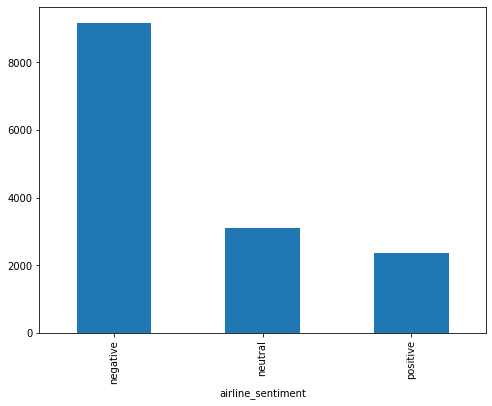

In [62]:

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_tweets.groupby('airline_sentiment').airline_sentiment.count().plot.bar(ylim=0)
plt.show()

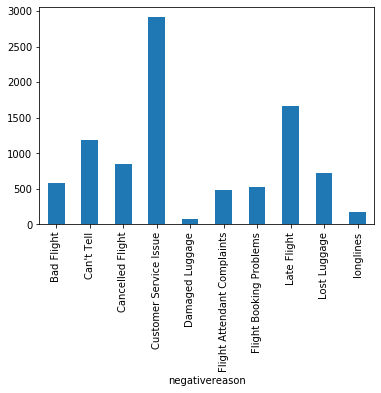

In [63]:
df_tweets.groupby('negativereason').negativereason.count().plot.bar(ylim=0)
plt.show()